In [1]:
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt

import numpy as np
import deepthought, mne, os

from deepthought.util.logging_util import configure_custom
configure_custom(debug=False)
mne.set_log_level('INFO')

### TODO: change this for each subject
subject = 'P01'

from deepthought.datasets.openmiir.metadata import get_stimuli_version
STIMULI_VERSION = get_stimuli_version(subject)

sfreq = 64.0

Couldn't import dot_parser, loading of dot files will not be possible.


In [2]:
from deepthought.experiments.bcmi2015.preprocessing import load_and_preprocess_raw
raw, trial_events, beat_events = load_and_preprocess_raw(subject, 
                                                         sfreq=sfreq, 
                                                         interpolate_bad_channels=True,
                                                         verbose=False)

Loading raw data for subject "P01" from /imaging/deepthought/datasets/OpenMIIR/eeg/mne/P01-raw.fif
540 events found
Events id: [  11   12   13   14   21   22   23   24   31   32   33   34   41   42   43
   44  111  112  113  114  121  122  123  124  131  132  133  134  141  142
  143  144  211  212  213  214  221  222  223  224  231  232  233  234  241
  242  243  244 1000 1111 2001]
This file contains some EEG channels marked as bad: [u'P8', u'P10', u'T8']
Interpolating bad channels...
Channel interpolation is currently only implemented for EEG. The MEG channels marked as bad will remain untouched.
Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 7
         Function evaluations: 289
Computing interpolation matrix from 61 sensor positions
Interpolating 3 sensors
Band-pass filtering from 0.5 - 30 Hz


[Parallel(n_jobs=4)]: Done   1 out of  61 | elapsed:    0.6s remaining:   37.9s
[Parallel(n_jobs=4)]: Done  11 out of  61 | elapsed:    2.1s remaining:    9.5s
[Parallel(n_jobs=4)]: Done  24 out of  61 | elapsed:    3.9s remaining:    6.0s
[Parallel(n_jobs=4)]: Done  37 out of  61 | elapsed:    5.7s remaining:    3.7s
[Parallel(n_jobs=4)]: Done  50 out of  61 | elapsed:    7.6s remaining:    1.7s
[Parallel(n_jobs=4)]: Done  61 out of  61 | elapsed:    9.1s finished


360 events found
Events id: [  11   12   13   14   21   22   23   24   31   32   33   34   41   42   43
   44  111  112  113  114  121  122  123  124  131  132  133  134  141  142
  143  144  211  212  213  214  221  222  223  224  231  232  233  234  241
  242  243  244 1111 2001]
trial events: (360, 3)
Loading stimulus metadata from /imaging/deepthought/datasets/OpenMIIR/meta/Stimuli_Meta.v1.xlsx


/usr/local/lib/python2.7/dist-packages/xlrd/xlsx.py:246: PendingDeprecationWarning: This method will be removed in future versions.  Use 'tree.iter()' or 'list(tree.iter())' instead.
  for elem in self.tree.getiterator():
/usr/local/lib/python2.7/dist-packages/xlrd/xlsx.py:292: PendingDeprecationWarning: This method will be removed in future versions.  Use 'tree.iter()' or 'list(tree.iter())' instead.
  for elem in self.tree.getiterator():


beat events: (7340, 3)
360 events found
Events id: [  11   12   13   14   21   22   23   24   31   32   33   34   41   42   43
   44  111  112  113  114  121  122  123  124  131  132  133  134  141  142
  143  144  211  212  213  214  221  222  223  224  231  232  233  234  241
  242  243  244 1111 2001]
Reading /imaging/deepthought/datasets/OpenMIIR/eeg/preprocessing/ica/P01-100p_64c-ica.fif ...
Isotrak not found
    Read a total of 1 projection items:
        Average EEG reference (1 x 64)  idle
Now restoring ICA solution ...
Ready.
<ICA  |  epochs decomposition, fit (fastica): 529100 samples, 61 components, channels used: "eeg", 4 sources marked for exclusion>
[0, 1, 3, 11]
Transforming to ICA space (61 components)
Zeroing out 4 ICA components
Inverse transforming to PCA space
Reconstructing sensor space signals from 61 PCA components


In [3]:
from deepthought.datasets.openmiir.preprocessing.events import filter_beat_events, filter_trial_events
from deepthought.analysis.tempo.autocorrelation import *
from deepthought.datasets.openmiir.metadata import load_stimuli_metadata
meta = load_stimuli_metadata(version=STIMULI_VERSION)

def get_trials(stim_id, cond):
    events = filter_trial_events(trial_events, [stim_id], [cond])
#     print 'selected events:', len(events)
#     print events

    start = 0
    if cond in [1,2]: # cued
        # NOTE: start > 0 does not work; need to shift event time
        offset = int(np.floor(meta[stim_id]['length_of_cue'] * raw.info['sfreq']))
        events[:,0] += offset            
        stop = meta[stim_id]['length_with_cue']
    else:
        stop = meta[stim_id]['length_without_cue']
#     print start, stop

    eeg_picks = mne.pick_types(raw.info, meg=False, eeg=True, eog=False, stim=False)
    epochs = mne.Epochs(raw, events, None,
                              tmin=start, tmax=stop, preload=True,
                              proj=False, picks=eeg_picks, verbose=False)
    return epochs

Loading stimulus metadata from /imaging/deepthought/datasets/OpenMIIR/meta/Stimuli_Meta.v1.xlsx


mean: 37
median: 36
mode: 32
max: 34
best pair: 72.00 36.00
expected:  71.00 213.00


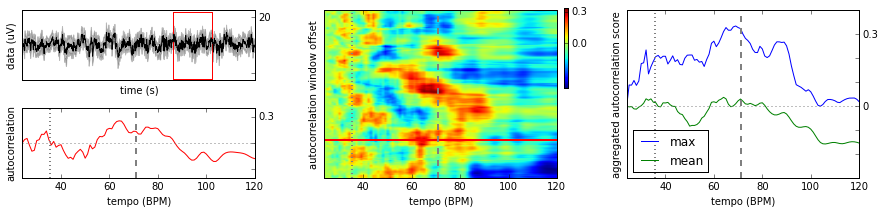

In [10]:
from matplotlib.patches import Rectangle
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import matplotlib as mpl
from deepthought.experiments.bcmi2015.tempo_prediction import sliding_window_tempo_analysis

def plot_sliding_window_tempo_analysis(stim_id, cond, tno, mode, verbose=False):
    
    HOP_SIZE = 5
    WINDOW_LENGTH = int(np.ceil(2.5*sfreq))
    # MAX_LENGTH = int(np.floor(6.8*sfreq)) # NOTE: shortest trial is 6.8709s
    MAX_LENGTH = int(np.floor(20*sfreq)) # NOTE: shortest trial is 6.8709s

    trials = get_trials(stim_id, cond)

    if tno == 'all':
        trial = trials.get_data()
        trial = np.asarray(trial).mean(axis=1)
    else:
        trial = trials.get_data()[tno]
    trial = trial.squeeze()
#     print trial.shape
    
    title = '{} - {} - cond. {}, trial {} ({})'.format(stim_id, meta[stim_id]['label'], cond, tno, mode)
    
    # use measured values instead of imprecise approx_bar_length
    #     gt_bar_step = meta[stim_id]['approx_bar_length'] * sfreq
    #     gt_beat_step = gt_bar_step / meta[stim_id]['beats_per_bar']
    #     gt_bpm = meta[stim_id]['bpm'] / float(meta[stim_id]['beats_per_bar'])
    gt_beat_tempo = float(meta[stim_id]['bpm'])
    gt_bar_tempo = float(gt_beat_tempo) / meta[stim_id]['beats_per_bar']
        
    skip_samples = 0
    max_samples = trial.shape[-1]
    max_samples = min(max_samples, MAX_LENGTH) 
    
    x = np.arange(24, 121, 1)
#     x = np.arange(45, 161, 1)
    
    plot_step_idx = 620 # offset for red window in plot
    
    def add_markers(best=None):
        if best is not None:
            plt.axvline(x[best[0]], color='red', linestyle='--', linewidth=2)
            plt.axvline(x[best[1]], color='red', linestyle=':', linewidth=2)
        if gt_beat_tempo is not None:
            if gt_beat_tempo < x[-1]:
                plt.axvline(gt_beat_tempo, color='gray', linestyle='--', linewidth=1)
    #         add_marker_lines(gt_beat_step, window_length, 'gray', linestyle='--', linewidth=1)
        if gt_bar_tempo is not None:
            if gt_bar_tempo < x[-1]:
                plt.axvline(gt_bar_tempo, color='gray', linestyle='--', linewidth=2)
            if 0.5 * gt_bar_tempo > x[0]:
                plt.axvline(0.5 * gt_bar_tempo, color='gray', linestyle=':', linewidth=2)
            if 2 * gt_bar_tempo < x[-1]:
                plt.axvline(2 * gt_bar_tempo, color='gray', linestyle=':', linewidth=2)
    #         add_marker_lines(gt_bar_step, window_length, 'red', linestyle=':', linewidth=1)

    fig = plt.figure(figsize=(15,3))
    subplot_grid = gridspec.GridSpec(2, 3, height_ratios=[1,1])

    axes = plt.subplot(subplot_grid[0, 0])

    data = trial
    times = np.arange(0, data.shape[-1], 1) / sfreq
    uV_scaling = 1e6

    mean = data.mean(axis=0)
    std = data.std(axis=0)
    hyp_limits = (mean - std, mean + std)                       # std

    axes.plot(times, uV_scaling * mean, color='black', linewidth=1)

    axes.set_xlim((times[0], times[-1]))
    axes.set_xlabel('time (s)')
    axes.set_ylabel('data (uV)')

    hyp_limits = uV_scaling * np.asarray(hyp_limits)
    axes.fill_between(times, hyp_limits[0], y2=hyp_limits[1], color='black', alpha=0.25)
    
    axes.yaxis.tick_right()
    axes.set_ylim((-25,25))
    axes.set_yticks([-20,0,20])
    axes.set_yticklabels(['', '', 20])
    plt.setp(axes.get_xticklabels(), visible=False)
    axes.set_xticks([])

    ## add sliding window
    ylim = axes.get_ylim()
    axes.add_patch(Rectangle(
                    (times[plot_step_idx], ylim[0]+1),
                    times[plot_step_idx+WINDOW_LENGTH] - times[plot_step_idx], 
                    ylim[1]-ylim[0]-2,
                    fill=False,
                    edgecolor='red', linewidth=1, linestyle='solid'))
    
    ## plot AC tempo curve of window
    window_data = trial.mean(axis=0)[plot_step_idx:plot_step_idx+WINDOW_LENGTH]
    ac = compute_autocorrelation(window_data)
    tempo_curve = compute_tempo_histogram_from_ac(ac, sfreq)
    y = tempo_curve(x)
    
    axes = plt.subplot(subplot_grid[1, 0])
    plt.xlabel('tempo (BPM)')
    plt.ylabel('autocorrelation')
    axes.yaxis.tick_right()
    axes.plot(x, y, color='red')
    plt.axhline(0, color='gray', linestyle=':', linewidth=1) # zero
    axes.set_xlim((x[0], x[-1]))
    axes.set_ylim((-0.4, 0.4))
    axes.set_yticks([-0.3, 0, 0.3])
    axes.set_yticklabels(['', '', 0.3])
    add_markers()
    
    best, im, best_pairs, best_scores = sliding_window_tempo_analysis(
        trial, sfreq, 
        min(x), max(x), 
        skip_samples, max_samples, 
        WINDOW_LENGTH, HOP_SIZE, 
        mode='median', verbose=verbose)
    
    im_mean = im.mean(axis=0)
    im_max = im.max(axis=0)

    if verbose:
        print 'best pair: {:.2f} {:.2f}'.format(*best)
        if gt_bar_tempo is not None:
            print 'expected:  {:.2f} {:.2f}'.format(gt_bar_tempo, gt_beat_tempo)

    
    axes = plt.subplot(subplot_grid[:, 1])
    axes.imshow(im, extent=[x[0],x[-1],len(im),0], aspect='auto') #, vmin=-1, vmax=1)
    plt.axhline(plot_step_idx / HOP_SIZE, color='red', linestyle='-', linewidth=2)
    plt.xlabel('tempo (BPM)')
    plt.ylabel('autocorrelation window offset')
    plt.yticks([])
    add_markers()
    
    cax = inset_axes(axes,
                 width="2%",
                 height="50%",
                 bbox_transform=axes.transAxes,
                 bbox_to_anchor=(0.025, 0.1, 1.05, 0.95),
                 loc= 1)
    norm = mpl.colors.Normalize(vmin=im.min(), vmax=im.max())
    cbar = mpl.colorbar.ColorbarBase(cax, 
                        cmap=matplotlib.cm.jet, norm=norm, 
                        orientation='vertical')
    cbar.set_ticks([0,0.3])

    axes = plt.subplot(subplot_grid[:, 2])
    plt.xlabel('tempo (BPM)')
    plt.ylabel('aggregated autocorrelation score')
    axes.plot(x, im_max, label='max')
    axes.plot(x, im_mean, label='mean')
    plt.xlim((x[0], x[-1]))
    plt.axhline(0, color='gray', linestyle=':', linewidth=1) # zero
    axes.yaxis.tick_right()
    add_markers()
    axes.set_yticks(np.arange(-0.3, 0.4, 0.1))
    axes.set_yticklabels(['','','',0,'','',0.3])
    axes.legend(loc='best')

    
#     plt.tight_layout()
    plt.subplots_adjust(wspace=0.3, hspace=0.4)

    return fig

    
fig = plot_sliding_window_tempo_analysis(1,2,0, 'median', verbose=True)
# fig.savefig('plots/sliding-window-analysis.pdf', bbox_inches='tight')

Note: This graphic looks slightly different then in the paper even though it is the same trial. The reason for this is that the preprocessing pipeline has been updated in the meantime. Most notably, bad channels have been identified and the artifact removal using ICA has been improved significantly.  
(Arrows were added later.)